In [1]:
%load_ext autoreload
%autoreload 2

# TransducedLM vs FusedTransducedLM Benchmark

Compares two approaches to computing next-symbol log-probabilities through
an FST on the Penn Treebank tokenizer (~296 states, 257 input symbols):

- **TransducedLM**: two-phase (PeekabooState BFS decomposition, then LM-weighted search)
- **FusedTransducedLM**: single-pass (interleaved decomposition + LM search, no separate BFS)

Uses a 3-gram CharNgramLM as the inner LM, with per-call timeouts and a
process-wide memory limit.

In [2]:
import time, gc
import numpy as np
from transduction.applications.ptb import build_ptb_fst_pynini, string_to_byte_strs, decode_ptb_output
from transduction.fsa import EPSILON
from transduction.util import Timeout, timelimit, set_memory_limit
set_memory_limit(8)

In [3]:
t0 = time.perf_counter()
ptb_fst = build_ptb_fst_pynini()
print(f'PTB FST built in {time.perf_counter()-t0:.1f}s: '
      f'{len(ptb_fst.states)} states, |A|={len(ptb_fst.A)}, |B|={len(ptb_fst.B)}')

Composing PTB rules...
Core PTB FST: 310 states
Final pynini FST: 296 states
Converting to native FST...
Native FST: 296 states, 23723 arcs
  eps: 108 in, 352 out
  MARKER: 0 in, 0 out
  [EOS]: 0 in, 0 out
PTB FST built in 31.4s: 296 states, |A|=257, |B|=256


In [4]:
# Generate target sequence via FST.transduce (PTB FST uses integer byte symbols directly)
text = "The quick brown fox jumps over the lazy dog."
byte_ints = string_to_byte_strs(text)
target_seq = list(ptb_fst.transduce(byte_ints))
decoded = decode_ptb_output(tuple(target_seq))
print(f'Target: {len(target_seq)} symbols')
print(f'  {decoded!r}')

# Train inner LM on integer byte symbols (CharNgramLM works with any hashable type)
from transduction.lm.ngram import CharNgramLM
source_alpha = ptb_fst.A - {EPSILON}
train_text = (
    "The quick  brown   fox    jumps     over the lazy dog. "
    "A stitch in time saves nine. To be or not to be, that is the question. "
    "All that glitters is not gold. Actions speak louder than words. "
    "Practice makes perfect. Where there is a will, there is a way. "
) * 3
train_syms = list(string_to_byte_strs(train_text))
for sym in source_alpha:
    train_syms.append(sym)
inner_lm = CharNgramLM.train(train_syms, n=3, alpha=0.5)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Target: 45 symbols
  'The quick brown fox jumps over the lazy dog .'
Inner LM: alphabet=257 symbols


In [5]:
decoded

'The quick brown fox jumps over the lazy dog .'

## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs.  For TransducedLM,
the PeekabooState BFS dominates (~35s per step on PTB).  FusedTransducedLM
avoids the BFS entirely but builds the lazy DFA inline during search.

Both use `max_steps=200`, `max_beam=100`, with a 120s timeout per step.

In [6]:
from collections import defaultdict
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM

MAX_DECODE = 100             # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 10                # max items carried forward
LM_TIMEOUT = 3               # seconds per step

# Expected runtime: ~15-20 min total (TransducedLM ~65s/step, FusedTransducedLM ~35s/step)

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

for name, cls in [
    ('FusedTransducedLM', FusedTransducedLM),
    ('TransducedLM', TransducedLM),
]:
    print(f'\n{name} (max_steps={MAX_SEARCH}, max_beam={MAX_BEAM}):')
    tlm = cls(inner_lm, ptb_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)
    try:
        with timelimit(LM_TIMEOUT):
            state = tlm.initial()
    except (Timeout, MemoryError) as e:
        print(f'  initial() failed: {type(e).__name__}: {e}')
        continue
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        try:
            with timelimit(LM_TIMEOUT):
                t0 = time.perf_counter()
                lp = state.logp_next[y]
                state = state >> y
                t1 = time.perf_counter()
        except Timeout:
            print(f'  step {i+1} TIMEOUT ({LM_TIMEOUT}s)')
            break
        except MemoryError:
            print(f'  step {i+1} OOM')
            break
        elapsed = t1 - t0
        lm_results[name].append((i + 1, elapsed, lp))
        print(f'  {i+1:2d}: {elapsed*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()


FusedTransducedLM (max_steps=200, max_beam=10):
  step 1 TIMEOUT (3s)

TransducedLM (max_steps=200, max_beam=10):
   1:      3.6 ms  logp=-4.8958
   2:     32.6 ms  logp=-3.6225
   3:     10.6 ms  logp=-3.5915
   4:     11.8 ms  logp=-2.0651
   5:    161.9 ms  logp=-3.5536
   6:     55.2 ms  logp=-2.9958
   7:     14.5 ms  logp=-3.6149
   8:     15.0 ms  logp=-3.5915
   9:     14.7 ms  logp=-3.6149
  10:     15.2 ms  logp=-2.3588
  11:    100.4 ms  logp=-6.4210
  12:     70.1 ms  logp=-3.6377
  13:     20.9 ms  logp=-3.5915
  14:     21.3 ms  logp=-3.5915
  15:     32.3 ms  logp=-3.6048
  16:     34.8 ms  logp=-2.3588
  17:    161.4 ms  logp=-6.8184
  18:     72.1 ms  logp=-3.5915
  19:     24.9 ms  logp=-3.5915
  20:     25.9 ms  logp=-2.3588
  21:     98.6 ms  logp=-6.7792
  22:     77.9 ms  logp=-3.5915
  23:     28.1 ms  logp=-3.5915
  24:     25.4 ms  logp=-3.5915
  25:     27.2 ms  logp=-3.5915
  26:     30.1 ms  logp=-2.3588
  27:    104.5 ms  logp=-6.9508
  28:     71.5 ms  lo

In [7]:
type(state)

transduction.lm.transduced.TransducedState

In [8]:
# Approximate posterior distribution over source strings given the target prefix.
# TransducedState._repr_html_ groups particles by (source, DFA state),
# normalizes log-weights, and renders an HTML table.
state

Source prefix,DFA state,Role,Count,log w,p(x|y)
'The quick brown fox jumps over the lazy dog.',35209,frontier,4,-161.26,0.9723
'The quick brown fox jumps over the lazy dog. ',35525,frontier,4,-164.88,0.0259
'The quick brown fox jumps over the lazy dog.>',35526,frontier,2,-167.52,0.0018


In [16]:
state._peekaboo_state

In [17]:
# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (s)":>12s} {"Steps":>6s}')
print('-' * 55)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data)
    print(f'{name:<25s} {total:10.1f} {avg:12.1f} {len(data):6d}')
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    t0 = sum(t for _, t, _ in d0)
    t1 = sum(t for _, t, _ in d1)
    if t1 > 0:
        print(f'\nFused speedup (overall): {t0/t1:.2f}x')
    # Exclude step 1 (amortization penalty for Fused)
    if len(d0) > 1 and len(d1) > 1:
        t0_skip1 = sum(t for _, t, _ in d0[1:])
        t1_skip1 = sum(t for _, t, _ in d1[1:])
        if t1_skip1 > 0:
            print(f'Fused speedup (step 2+): {t0_skip1/t1_skip1:.2f}x')


Algorithm                  Total (s) Avg/step (s)  Steps
-------------------------------------------------------
TransducedLM                     2.3          0.1     45


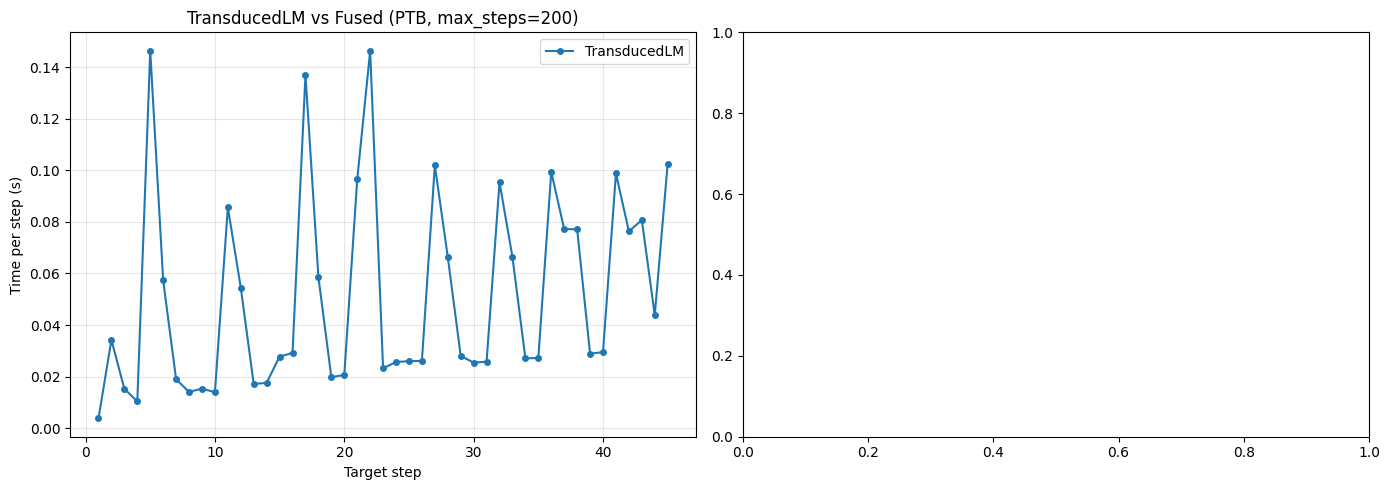

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: time per step
ax = axes[0]
for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] for d in data]
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step')
ax.set_ylabel('Time per step (s)')
ax.set_title(f'TransducedLM vs Fused (PTB, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: per-step speedup
ax = axes[1]
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    n = min(len(d0), len(d1))
    steps = [d0[i][0] for i in range(n)]
    speedups = [d0[i][1] / d1[i][1] if d1[i][1] > 0 else 0 for i in range(n)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    ax.bar(steps, speedups, color=colors, alpha=0.7, edgecolor='white')
    ax.axhline(1.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Target step')
    ax.set_ylabel('Speedup (Original / Fused)')
    ax.set_title('Per-step speedup (>1 = Fused faster)')
    ax.grid(True, alpha=0.3, axis='y')

    logp_diffs = [abs(d0[i][2] - d1[i][2]) for i in range(n)]
    print(f'Max |logp| diff: {max(logp_diffs):.6f}')

plt.tight_layout()
plt.show()